<a href="https://colab.research.google.com/github/saeedzou/DeepLearning1401-01/blob/main/Assignment%204/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries for pytorch to train a sequence-to-sequence model using LSTM cells to generate poems of Ferdousi
# the dataset is in ferdousi.txt which is in persian
# the model is trained on a GPU
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# # for persian
# !pip install hazm -q
# from hazm import *
import string
from collections import Counter
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git
!cp Persian_poems_corpus/original/ferdousi.txt .
!rm -rf Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 11.20 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (148/148), done.


In [3]:
class Vocabulary:
    def __init__(self, poem_path, threshold):
        self.poem_path = poem_path
        self.threshold = threshold
        self.load_poem()
        self.build_vocab()
        
    def load_poem(self):
        with open(self.poem_path, 'r', encoding='utf-8') as f:
            poem = [line.strip() for line in f.readlines()]
        poem = poem[2:]
        poem = poem[:-1] if len(poem) % 2 == 1 else poem
        poem = [[poem[i], poem[i+1]] for i in range(0, len(poem), 2)]
        poem = [mesra[0] + ' <sep> ' + mesra[1] for mesra in poem]
        punctuations = string.punctuation + '«»،؛؟'
        self.lines = [[word.lower() for word in line.split() if word not in punctuations] for line in poem]
    
    def build_vocab(self):
        words = [word for line in self.lines for word in line]
        word_counts = Counter(words)
        words = [word for word, count in word_counts.items() if count >= self.threshold]
        self.word2idx = {word: idx for idx, word in enumerate(words)}
        self.word2idx['<pad>'] = len(self.word2idx)
        self.word2idx['<sos>'] = len(self.word2idx)
        self.word2idx['<eos>'] = len(self.word2idx)
        self.word2idx['<unk>'] = len(self.word2idx)
        self.word2idx['<sep>'] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

In [4]:
class FerdousiDataset(torch.utils.data.Dataset):
    def __init__(self, poem_path, vocab):
        self.poem_path = poem_path
        self.vocab = vocab
        self.load_poem()

    def __len__(self):
        return len(self.poem) - 1

    def __getitem__(self, idx):
        return self.poem[idx], self.poem[idx + 1]

    def load_poem(self):
        with open(self.poem_path, 'r', encoding='utf-8') as f:
            poem = [line.strip() for line in f.readlines()]
        poem = poem[2:]
        poem = poem[:-1] if len(poem) % 2 == 1 else poem
        poem = [[poem[i], poem[i + 1]] for i in range(0, len(poem), 2)]
        poem = [mesra[0] + ' <sep> ' + mesra[1] for mesra in poem]
        poem = [word_tokenize(line) for line in poem]
        punctuations = string.punctuation + '«»،؛؟'
        poem = [[word for word in line if word not in punctuations] for line in poem]
        poem = [line for line in poem if len(line) > 0]
        poem = [[word for word in line if len(word) > 1] for line in poem]
        self.max_len = max([len(line) for line in poem])
        poem = [line + ['<pad>'] * (self.max_len - len(line)) for line in poem]
        poem = [['<sos>'] + line + ['<eos>'] for line in poem]

        # Create word vectors using the vocabulary
        self.poem = []
        for line in poem:
            line_vec = []
            for word in line:
                if word in self.vocab.word2idx:
                    line_vec.append(self.vocab.word2idx[word])
                else:
                    line_vec.append(self.vocab.word2idx['<unk>'])
            self.poem.append(line_vec)
        self.poem = torch.tensor(self.poem).long()

vocab = Vocabulary('ferdousi.txt', 2)
# create a dataset object
dataset = FerdousiDataset('ferdousi.txt', vocab)
# split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# create a dataloader for train and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden=None, cell=None):
        # x.shape = (batch_size, seq_len)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, seq_len, embedding_size)
        if hidden is None and cell is None:
            hidden = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
            cell = torch.zeros((self.num_layers, x.shape[0], self.hidden_size), device=x.device)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs.shape = (batch_size, seq_len, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        return hidden, cell

# define the decoder class and use the encoder.embedding as the embedding layer
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p_drop=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder.embedding
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden, cell):
        # x.shape = (batch_size, 1)
        x = x.unsqueeze(1)
        # x.shape = (batch_size, 1, 1)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, 1, embedding_size)
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs.shape = (batch_size, 1, hidden_size)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        predictions = self.fc(outputs)
        # predictions.shape = (batch_size, 1, output_size)
        predictions = predictions.squeeze(1)
        # predictions.shape = (batch_size, output_size)
        return predictions, hidden, cell

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.8):
        # source.shape = (batch_size, source_seq_len)
        # target.shape = (batch_size, target_seq_len)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.vocab.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden, cell = self.encoder(source)
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = target[:, 0]
        # x.shape = (batch_size)
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            # output.shape = (batch_size, target_vocab_size)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs

In [7]:
# encoder hyperparameters
input_size_encoder = len(dataset.vocab.word2idx)
encoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the encoder
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
# decoder hyperparameters
input_size_decoder = len(dataset.vocab.word2idx)
output_size = len(dataset.vocab.word2idx)
decoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the decoder
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
num_epochs = 25
learning_rate = 1e-3
# initialize the network
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model = Seq2Seq(encoder_net, decoder_net).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>']]
    return ' '.join(words)

# define a function that generates a verse
def generate_verse(model, source, device, tensor2string, max_len=20):
    source = source.unsqueeze(0)
    model.eval()
    # dont forget to move to device
    with torch.no_grad():
        hidden, cell = model.encoder(source.to(device))
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = torch.tensor([dataset.vocab.word2idx['<sos>']]).to(device)
        outputs = []
        for t in range(max_len):
            output, hidden, cell = model.decoder(x, hidden, cell)
            # output.shape = (1, output_size)
            best_guess = output.argmax(1)
            outputs.append(best_guess.item())
            x = best_guess
            if best_guess.item() == dataset.vocab.word2idx['<eos>']:
                break
    return tensor2string(torch.tensor(outputs))

In [15]:
# define a function that trains the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, generate_verse, tensor2string):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        idx = random.randint(0, len(train_dataset))
        verse = train_dataset[idx][0].to(device)
        print(generate_verse(model, verse, tensor2string=tensor2string, device=device))
        model.train()
        for (source, target) in train_loader:
            source = source.to(device)
            target = target.to(device)
            outputs = model(source, target)
            # outputs.shape = (batch_size, target_seq_len, output_size)
            outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
            # outputs.shape = (batch_size * target_seq_len, output_size)
            target = target[:, 1:].reshape(-1)
            # target.shape = (batch_size * target_seq_len)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top_p, top_class = outputs.topk(1, dim=1)
            # top_p.shape = (batch_size * target_seq_len, 1)
            # top_class.shape = (batch_size * target_seq_len, 1)
            equals = top_class == target.view(*top_class.shape)
            # equals.shape = (batch_size * target_seq_len, 1)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy / len(train_loader))
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for (source, target) in val_loader:
                source = source.to(device)
                target = target.to(device)
                outputs = model(source, target)
                # outputs.shape = (batch_size, target_seq_len, output_size)
                outputs = outputs[:, 1:].reshape(-1, outputs.shape[2])
                # outputs.shape = (batch_size * target_seq_len, output_size)
                target = target[:, 1:].reshape(-1)
                # target.shape = (batch_size * target_seq_len)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                top_p, top_class = outputs.topk(1, dim=1)
                # top_p.shape = (batch_size * target_seq_len, 1)
                # top_class.shape = (batch_size * target_seq_len, 1)
                equals = top_class == target.view(*top_class.shape)
                # equals.shape = (batch_size * target_seq_len, 1)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {val_accuracies[-1]:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, generate_verse, tensor2string)

کاه مراست مراست مراست بروها چرپ چرپ نابخردان نابخردان نماندش نماندش زآهن دمساز دمساز بیور بیور بگریستی بکنده سپیدش روشنک
Epoch 1/25 | Train Loss: 5.9711 | Train Accuracy: 0.1225 | Val Loss: 5.7113 | Val Accuracy: 0.1315
چو تا به از به <unk> <unk> <unk> که از از از از به <unk> به راه بود
Epoch 2/25 | Train Loss: 5.5815 | Train Accuracy: 0.1348 | Val Loss: 5.5157 | Val Accuracy: 0.1394
چو گفت کای شاه <unk> <unk> که از <unk> را به راه بود بود
Epoch 3/25 | Train Loss: 5.3898 | Train Accuracy: 0.1426 | Val Loss: 5.3576 | Val Accuracy: 0.1463
چو گفت به نزدیک شاه <unk> <unk> که از <unk> از داد یاد کرد جفت جفت
Epoch 4/25 | Train Loss: 5.2259 | Train Accuracy: 0.1483 | Val Loss: 5.2339 | Val Accuracy: 0.1514
چو گفت با شاه <unk> که از <unk> بود با سپاه راه بود جفت جفت اوی
Epoch 5/25 | Train Loss: 5.0854 | Train Accuracy: 0.1537 | Val Loss: 5.1415 | Val Accuracy: 0.1572
چو گفت با او به <unk> <unk> <unk> که از <unk> از تو بر گاه شاه سپاه
Epoch 6/25 | Train Loss: 4.9716 | Train Accuracy: 0.1587 | V

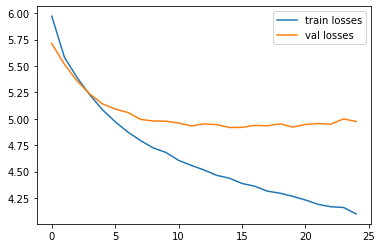

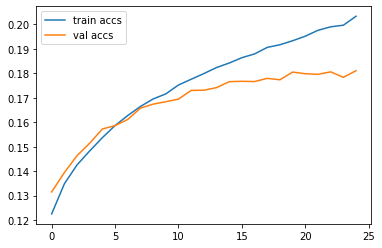

In [17]:
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='val losses')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train accs')
plt.plot(val_accuracies, label='val accs')
plt.legend()
plt.show()

To generate verses I only select those generated verses that have unique words in them and their length is more than 12

In [23]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string_unk(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>', '<unk>']]
    return ' '.join(words)
print("Some Generated Verses: ")
i = 0
while not i == 10:
  idx = random.randint(0, len(train_dataset))
  verse = train_dataset[idx][0].to(device)
  generated = generate_verse(model, verse, tensor2string=tensor2string_unk, device=device)
  if len(generated.split()) > 12:
    counts = Counter(generated.split())
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    if counts[0][1] == 1:
      i += 1
      print(generated)

Some Generated Verses: 
بزرگان که بودند با او به پیش اندرون افگند در کارزار اوی راه
چو بشنید شاه آن زمان که ای نامور پهلوان را بخوان در نهفت
دگر گفت کز کار من که از به دست رس ای همام رنج
چو از بر شاه شد شهریار همی گفت با داور پاک خوار تلخ گشت
چو از بر شاه شد شهریار همی رفت با او به روزگار تلخ خیر آب چشم
چو از بر شاه شد شهریار همی گفت با داور پاک تلخ روان گشت
چنین گفت با شاه اسفندیار که ای پرهنر شهریار بلند مدار ایچ تاو دیر سترگ
چو از بر شاه شد شهریار همی رفت با او به روزگار تلخ خیر آب چشم
چو بشنید شاه آن زمان که با او از نهفت اندر آمد به روی
چو از بر شاه شد شهریار همی رفت با او به روزگار تلخ خیر آب


In [24]:
# define another encoder with Bidirectional GRU
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p_drop=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x):
        # x.shape = (batch_size, seq_len)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, seq_len, embedding_size)
        outputs, hidden = self.gru(embedding)
        # outputs.shape = (batch_size, seq_len, hidden_size * 2)
        # hidden.shape = (num_layers * 2, batch_size, hidden_size)
        return hidden

# define decoder with bidirectional GRU
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p_drop=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = encoder.embedding
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # since bidirectional, so multiply by 2
        self.dropout = nn.Dropout(p_drop)

    def forward(self, x, hidden):
        # x.shape = (batch_size, 1)
        x = x.unsqueeze(1)
        # x.shape = (batch_size, 1, 1)
        embedding = self.dropout(self.embedding(x))
        # embedding.shape = (batch_size, 1, embedding_size)
        outputs, hidden = self.rnn(embedding, hidden)
        # outputs.shape = (batch_size, 1, hidden_size * 2)  # since bidirectional, so hidden_size * 2
        # hidden.shape = (num_layers * 2, batch_size, hidden_size)  # since bidirectional, so num_layers * 2
        predictions = self.fc(outputs)
        # predictions.shape = (batch_size, 1, output_size)
        predictions = predictions.squeeze(1)
        # predictions.shape = (batch_size, output_size)
        return predictions, hidden

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source.shape = (batch_size, source_seq_len)
        # target.shape = (batch_size, target_seq_len)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = len(dataset.vocab.word2idx)
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        hidden = self.encoder(source)
        # hidden.shape = (batch_size, 2*hidden_size)
        x = target[:, 0]
        # x.shape = (batch_size)
        for t in range(1, target_len):
            output, hidden = self.decoder(x, hidden)
            # output.shape = (batch_size, target_vocab_size)
            outputs[:, t] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess
        return outputs


In [26]:
# hyperparameters
input_size_encoder = len(dataset.vocab.word2idx)
encoder_embedding_size = 200
hidden_size = 128
num_layers = 2
# define the encoder
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)
# hyperparameters
input_size_decoder = len(dataset.vocab.word2idx)
output_size = len(dataset.vocab.word2idx)
decoder_embedding_size = 200
hidden_size = 128
num_layers = 2
num_epochs = 25
# define the decoder
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers).to(device)
model = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.word2idx['<pad>'])

In [27]:
# define a function that generates a verse for gru model
def generate_verse_gru(model, source, device, tensor2string, max_len=20):
    source = source.unsqueeze(0)
    model.eval()
    # dont forget to move to device
    with torch.no_grad():
        hidden = model.encoder(source.to(device))
        # hidden.shape = (num_layers, batch_size, hidden_size)
        # cell.shape = (num_layers, batch_size, hidden_size)
        x = torch.tensor([dataset.vocab.word2idx['<sos>']]).to(device)
        outputs = []
        for t in range(max_len):
            output, hidden = model.decoder(x, hidden)
            # output.shape = (1, output_size)
            best_guess = output.argmax(1)
            outputs.append(best_guess.item())
            x = best_guess
            if best_guess.item() == dataset.vocab.word2idx['<eos>']:
                break
    return tensor2string(torch.tensor(outputs))

In [28]:
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, generate_verse_gru, tensor2string)

بانگشت بانگشت بانگشت دیوانها جهاندیدگان جهاندیدگان جهاندیدگان جهاندیدگان جهاندیدگان زینش کامشان بدش جنگاور جنگاور نژادم رفتنش خوارتر چندگاه چامهٔ چامهٔ
Epoch 1/25 | Train Loss: 6.0176 | Train Accuracy: 0.1209 | Val Loss: 5.8186 | Val Accuracy: 0.1267
چو گفت که از <unk> <unk> <unk> <unk> <unk> را به بر تو را بود نیست
Epoch 2/25 | Train Loss: 5.7049 | Train Accuracy: 0.1289 | Val Loss: 5.6772 | Val Accuracy: 0.1305
چو از بر <unk> <unk> <unk> <unk> از بر <unk> <unk> <unk> شد از از راه اوی <unk>
Epoch 3/25 | Train Loss: 5.5486 | Train Accuracy: 0.1340 | Val Loss: 5.5678 | Val Accuracy: 0.1366
چو گفت که که <unk> <unk> <unk> <unk> <unk> به از به به بود جفت
Epoch 4/25 | Train Loss: 5.4122 | Train Accuracy: 0.1381 | Val Loss: 5.5229 | Val Accuracy: 0.1378
چو گفت از <unk> <unk> <unk> <unk> <unk> به <unk> به به راه <unk>
Epoch 5/25 | Train Loss: 5.2982 | Train Accuracy: 0.1413 | Val Loss: 5.4561 | Val Accuracy: 0.1414
بدو گفت کای که <unk> <unk> <unk> <unk> از تو تو را نهفت نیست جفت
Epoch 6/25 | 

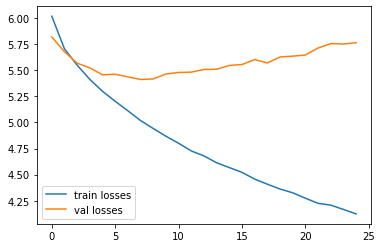

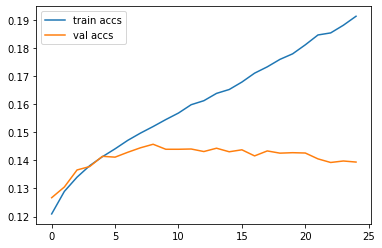

In [30]:
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='val losses')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train accs')
plt.plot(val_accuracies, label='val accs')
plt.legend()
plt.show()

In [34]:
# define a function that takes a tensor of indices and returns a string and removes pad and end and start tokens
def tensor2string(tensor):
    # tensor.shape = (seq_len)
    words = [dataset.vocab.idx2word[idx.item()] for idx in tensor]
    words = [word for word in words if word not in ['<pad>', '<sos>', '<eos>', '<unk>']]
    return ' '.join(words)
print("Some Generated Verses: ")
i = 0
while not i == 10:
  idx = random.randint(0, len(train_dataset))
  verse = train_dataset[idx][0].to(device)
  generated = generate_verse_gru(model, verse, tensor2string=tensor2string, device=device)
  generated_verses = []
  if len(generated.split()) > 12:
    counts = Counter(generated.split())
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    if counts[0][1] == 1 and generated not in generated_verses:
      generated_verses.append(generated)
      i += 1
      print(generated)

Some Generated Verses: 
به پیش اندرون کرد یکی بیشه زد بر میان دو لب پر خون
چنین گفت کای شاه خسرونژاد که دل مدارید باک منست آورم یاد کرد
به منذر چنین گفت کای سرکشان که ای مرد بدساز دل روان را سپرد ایچ تاو
خروشی برآمد ایران سپاه که آمد از کشور سیاه رزمگاه خواه نو کلاه گاه
کنون کار بگشای بر خیره شد روی گیتی پر از خون گشت چشم
یکی نامه بنوشت نزدیک شاه که ای مرد بینادل نیک خواه نگاه گناه
بدو گفت بندوی کای سرفراز چرا تیره گشتم مرا دراز فراز آر راز وگوی
چنین گفت پیران که ای کن بدین کار ما را خواه نو کنم
چو این سخن جز از راستی نباید که او را رها کاستی نیست جفت
چو آگاهی آمد بافراسیاب سوی شاه ایران بنهاد روی زمین پر تذرو کرد
